In [120]:
import pandas as pd
import os
import tensorflow as tf

import scipy
from scipy.io import loadmat
import re

import string
import imageio
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import random
import time
import nltk

import warnings
warnings.filterwarnings('ignore')

In [121]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path+'/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path+'/word2Id.npy'))
id2word_dict =  dict(np.load(dictionary_path+'/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s'%('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s'%('2428', id2word_dict['2428']))
print('Tokens: <PAD>: %s; <RARE>: %s'%(word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 2428 -> polkadots
Tokens: <PAD>: 5427; <RARE>: 5428


In [122]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    tokens = []
    tokens.extend(nltk.tokenize.word_tokenize(prep_line.lower()))
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    for i in range(padding):
        tokens.append('<PAD>')
    line = [word2Id_dict[tokens[k]] if tokens[k] in word2Id_dict else word2Id_dict['<RARE>'] for k in range(len(tokens))]
    
    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [123]:
data_path = './dataset'
df = pd.read_pickle(data_path+'/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data'%(n_images_train))

There are 7370 image in training data


In [124]:
import numpy as np
from scipy import misc
import random
import skimage
import skimage.io
import skimage.transform
def load_image_array(image_file, image_size):
    img = skimage.io.imread(image_file)
    # GRAYSCALE
    if len(img.shape) == 2:
        img_new = np.ndarray( (img.shape[0], img.shape[1], 3), dtype = 'uint8')
        img_new[:,:,0] = img
        img_new[:,:,1] = img
        img_new[:,:,2] = img
        img = img_new

    img_resized = skimage.transform.resize(img, (image_size, image_size))

    # FLIP HORIZONTAL WIRH A PROBABILITY 0.5
    if random.random() > 0.5:
        img_resized = np.fliplr(img_resized)
    
    
    return img_resized.astype('float32')

In [125]:
def produce_wrong_img(self):
    wrong_images = np.zeros((64, 64, 64, 3))
    cnt = 0
    for i in range(64):
        wrong_image_id = random.randint(0,7370)
        impath = df['ImagePath'].values[wrong_image_id]
        wrong_image_array = load_image_array(data_path+impath,64)
        wrong_images[cnt, :,:,:] = wrong_image_array
        cnt+=1
    return wrong_images

In [126]:
#df.head(5)
#print(df.ix[:3, "Captions"])
#print((df['Captions'].values[4])[2])
captions = df['Captions'].values
caption = []
for i in range(64):
    caption.append(random.choice(captions[i])) 
caption = np.asarray(caption)
print(caption.shape)


(64, 20)


In [127]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_DEPTH = 3
def training_data_generator(caption,image_path):
    # load in the image according to image path
    imagefile = tf.read_file(data_path +  image_path)
    image = tf.image.decode_image(imagefile, channels=3)
    float_img = tf.image.convert_image_dtype(image, tf.float32)
    float_img.set_shape([None, None, 3])
    image = tf.image.resize_images(float_img, size = [IMAGE_HEIGHT, IMAGE_WIDTH])
    image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_brightness(image, max_delta=63)
    return image, caption

def data_iterator(filenames, batch_size, data_generator):
    # Load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    captions = df['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(random.choice(captions[i])) 
    caption = np.asarray(caption)
    image_path = df['ImagePath'].values

    # Assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes
    
    return iterator, output_types, output_shapes

In [128]:
tf.reset_default_graph()
BATCH_SIZE = 64
iterator_train, types, shapes = data_iterator(data_path+'/text2ImgData.pkl', BATCH_SIZE, training_data_generator)
iter_initializer = iterator_train.initializer
next_element = iterator_train.get_next()

with tf.Session() as sess:
    sess.run(iterator_train.initializer)
    next_element = iterator_train.get_next()
    image, text = sess.run(next_element)
    print(image.shape)

(64, 64, 64, 3)


In [129]:
class TextEncoder:
    """
    Encode text (a caption) into hidden representation
    input: text (a list of id)
    output: hidden representation of input text in dimention of TEXT_DIM
    """
    def __init__(self, text, hparas, training_phase=True, reuse=False, return_embed=False):
        self.text = text
        self.hparas = hparas
        self.train = training_phase
        self.reuse = reuse
        self._build_model()
    def _build_model(self):
        with tf.variable_scope('rnnftxt', reuse=self.reuse):
            # Word embedding
            word_embed_matrix = tf.get_variable('rnn/wordembed', 
                                                shape=(self.hparas['VOCAB_SIZE'], self.hparas['EMBED_DIM']),
                                                initializer=tf.random_normal_initializer(stddev=0.02),
                                                dtype=tf.float32)
            embedded_word_ids = tf.nn.embedding_lookup(word_embed_matrix, self.text)
            # RNN encoder
            LSTMCell = tf.nn.rnn_cell.LSTMCell(self.hparas['TEXT_DIM'], reuse=self.reuse)
            initial_state = LSTMCell.zero_state(self.hparas['BATCH_SIZE'], dtype=tf.float32)
            rnn_net = tf.nn.dynamic_rnn(cell=LSTMCell, 
                                        inputs=embedded_word_ids, 
                                        initial_state=initial_state, 
                                        dtype=np.float32, time_major=False,
                                        scope='rnn/dynamic')
            self.rnn_net = rnn_net
            self.outputs = rnn_net[0][:, -1, :]

In [130]:
def conv2d(input_, output_dim, 
           k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
           name="conv2d"):
    with tf.variable_scope(name):
        
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

        return conv

def deconv2d(input_, output_shape,
             k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
             name="deconv2d"):
    with tf.variable_scope(name):
        
        w = tf.get_variable('w', [k_h, k_h, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))


        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,strides=[1, d_h, d_w, 1])



        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        
        return deconv

In [131]:
class Generator:
    def __init__(self, noise_z, text, training_phase, hparas, reuse):
        self.z = noise_z
        self.text = text
        self.train = training_phase
        self.hparas = hparas
        self.gf_dim = 128
        self.reuse = reuse
        self._build_model()
        
    def _build_model(self):
        relu = tf.nn.relu
        #deconv2d = tf.layers.conv2d_transpose
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope('generator', reuse=self.reuse):
            text_flatten = tf.contrib.layers.flatten(self.text)
            text_input = tf.layers.dense(text_flatten, self.hparas['TEXT_DIM'], name='generator/text_input', reuse=self.reuse)
            z_text_concat = tf.concat([self.z, text_input], axis=1, name='generator/z_text_concat')
            #g_net = tf.layers.dense(z_text_concat, 64*64*3, name='generator/g_net', reuse=self.reuse)
            
            s = 64
            s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16)
            
            
            z_ = linear(z_text_concat, self.gf_dim*8*s16*s16)
            h0 = tf.reshape(z_, [-1, s16, s16, self.gf_dim * 8])
            h0 = relu(bn(h0, training=True))
            
            h1 = deconv2d(h0, [self.hparas['BATCH_SIZE'], s8, s8, self.gf_dim*4], name='g_h1')
            h1 = relu(bn(h1, training=True))
            
            h2 = deconv2d(h1, [self.hparas['BATCH_SIZE'], s4, s4, self.gf_dim*2], name='g_h2')
            h2 = relu(bn(h2, training=True))
            
            h3 = deconv2d(h2, [self.hparas['BATCH_SIZE'], s2, s2, self.gf_dim*1], name='g_h3')
            h3 = relu(bn(h3, training=True))
            
            h4 = deconv2d(h3, [self.hparas['BATCH_SIZE'], s, s, 3], name='g_h4')
            
            #g_net = tf.reshape(g_net, [-1, 64, 64, 3], name='generator/g_net_reshape')
            
            g_net = tf.nn.tanh(h4)
            
            self.generator_net = g_net
            self.outputs = g_net

In [132]:
def flatten(input, name):
    input_shape = input.get_shape()
    dim = 1
    for d in input_shape[1:].as_list():
        dim *= d
        input = tf.reshape(input, [-1, dim])
    
    return input


In [133]:
class pretrain:
    def __init__(self, intput, hparas,  training_phase=True, reuse=False):
        self.input=intput
        self.hparas=hparas
        self.train = training_phase
        self.reuse = reuse
        self.df_dim = 128 
        self._build_model()
    def _build_model(self):
        lrelu = tf.nn.leaky_relu
        bn = tf.layers.batch_normalization
        with tf.variable_scope('cnnftxt', reuse=self.reuse):
            h0=lrelu(bn(conv2d(self.input, self.df_dim,4,4,2,2, name = 'pre_h0' ), training=True))
            h1=lrelu(bn(conv2d(h0,self.df_dim*2,4,4,2,2,name = 'pre_h1' ), training=True))
            h2=lrelu(bn(conv2d(h1,self.df_dim*4,4,4,2,2,name = 'pre_h2' ), training=True))
            h3=lrelu(bn(conv2d(h2,self.df_dim*8,4,4,2,2,name = 'pre_h3' ), training=True))
            h4 = flatten(h3,name = 'pre_h4')
            h4 = tf.layers.dense(h4, units = self.hparas['TEXT_DIM'])
            self.outputs = h4



In [134]:
# resnet structure
class Discriminator:
    def __init__(self, image, text, training_phase, hparas, reuse):
        self.image = image
        self.text = text
        self.train = training_phase
        self.hparas = hparas
        self.df_dim = 128
        self.reuse = reuse
        self._build_model()
    
    def _build_model(self): 
        lrelu = tf.nn.leaky_relu
        #conv2d = tf.layers.conv2d
        bn = tf.layers.batch_normalization
        linear = tf.layers.dense
        with tf.variable_scope('discriminator', reuse=self.reuse):
            
            h0 = lrelu(conv2d(self.image, self.df_dim, name = 'd_h0_conv')) 
            h1 = lrelu(bn(conv2d(h0, self.df_dim*2, name = 'd_h1_conv'), training=True)) 
            h2 = lrelu(bn(conv2d(h1, self.df_dim*4, name = 'd_h2_conv'), training=True)) 
            h3 = lrelu(bn(conv2d(h2, self.df_dim*8, name = 'd_h3_conv'), training=True)) 

            reduced_text_embeddings = lrelu(linear(self.text,self.df_dim))
            reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings,1)
            reduced_text_embeddings = tf.expand_dims(reduced_text_embeddings,2)
            tiled_embeddings = tf.tile(reduced_text_embeddings, [1,4,4,1], name='tiled_embeddings')

            h3_concat = tf.concat( [h3, tiled_embeddings], axis = 3,name='h3_concat')
            h3_new = lrelu(bn(conv2d(h3_concat, self.df_dim*8, 1,1,1,1, name = 'd_h3_conv_new')))
            d_net = linear(tf.reshape(h3_new, [self.hparas['BATCH_SIZE'], -1]), 1,)
            self.logits = d_net
            self.discriminator_net = d_net
            self.outputs =  tf.nn.sigmoid(d_net)          

            

            


In [135]:
def get_hparas():
    hparas = {
        'MAX_SEQ_LENGTH' : 20,
        'EMBED_DIM' : 256, # word embedding dimension
        'VOCAB_SIZE' : len(vocab),
        'TEXT_DIM' : 128, # text embedding dimension
        'RNN_HIDDEN_SIZE' : 128,
        'Z_DIM' : 512, # random noise z dimension
        'IMAGE_SIZE' : [64, 64, 3], # render image size
        'BATCH_SIZE' : 64,
        'LR' : 0.0002,
        'BETA' : 0.5, # AdamOptimizer parameter
        'N_EPOCH' : 100,
        'N_SAMPLE' : num_training_sample
    }
    return hparas

In [136]:
def cosine_similarity(v1, v2):
    cost = tf.reduce_sum(tf.multiply(v1, v2), 1) / (tf.sqrt(tf.reduce_sum(tf.multiply(v1, v1), 1)) * tf.sqrt(tf.reduce_sum(tf.multiply(v2, v2), 1)))
    return cost

In [142]:
class GAN:
    def __init__(self, hparas, training_phase, dataset_path, ckpt_path, inference_path, recover=None):
        self.hparas = hparas
        self.train = training_phase
        self.dataset_path = dataset_path # dataPath+'/text2ImgData.pkl'
        self.ckpt_path = ckpt_path
        self.sample_path = './samples'
        self.inference_path = './inference'
        
        self._get_session() # get session
        self._get_train_data_iter() # initialize and get data iterator
        self._input_layer() # define input placeholder
        self._get_inference() # build generator and discriminator
        self._get_loss() # define gan loss
        self._get_var_with_name() # get variables for each part of model
        self._optimize() # define optimizer
        self._init_vars()
        self._get_saver()
        
        if recover is not None:
            self._load_checkpoint(recover)
            
            
        
    def _get_train_data_iter(self):
        if self.train: # training data iteratot
            iterator_train, types, shapes = data_iterator(self.dataset_path+'/text2ImgData.pkl',
                                                          self.hparas['BATCH_SIZE'], training_data_generator)
            iter_initializer = iterator_train.initializer
            self.next_element = iterator_train.get_next()
            self.sess.run(iterator_train.initializer)
            self.iterator_train = iterator_train
        else: # testing data iterator
            iterator_test, types, shapes = data_iterator_test(self.dataset_path+'/testData.pkl', self.hparas['BATCH_SIZE'])
            iter_initializer = iterator_test.initializer
            self.next_element = iterator_test.get_next()
            self.sess.run(iterator_test.initializer)
            self.iterator_test = iterator_test
            
    def _input_layer(self):
        if self.train:
            self.real_image = tf.placeholder('float32',
                                              [self.hparas['BATCH_SIZE'], self.hparas['IMAGE_SIZE'][0],
                                               self.hparas['IMAGE_SIZE'][1], self.hparas['IMAGE_SIZE'][2]],
                                              name='real_image')
            '''add wrong image'''
            self.wrong_image = tf.placeholder('float32',
                                              [self.hparas['BATCH_SIZE'], self.hparas['IMAGE_SIZE'][0],
                                               self.hparas['IMAGE_SIZE'][1], self.hparas['IMAGE_SIZE'][2]],
                                              name='wrong_image')
            '''add wrong image'''
            self.caption = tf.placeholder(dtype=tf.int64, shape=[self.hparas['BATCH_SIZE'], None], name='caption')
            self.wrong_caption = tf.placeholder(dtype=tf.int64, shape=[self.hparas['BATCH_SIZE'], None], name='wrong_caption')
            self.z_noise = tf.placeholder(tf.float32, [self.hparas['BATCH_SIZE'], self.hparas['Z_DIM']], name='z_noise')
            angles = tf.random_uniform([64], minval=-15.0 * np.pi / 180.0, maxval=15.0 * np.pi / 180.0, dtype=tf.float32, seed=9487)
            self.real_image = tf.contrib.image.rotate(self.real_image, angles, interpolation='NEAREST')
            self.wrong_image = tf.contrib.image.rotate(self.wrong_image, angles, interpolation='NEAREST')
        else:
            self.caption = tf.placeholder(dtype=tf.int64, shape=[self.hparas['BATCH_SIZE'], None], name='caption')
            self.z_noise = tf.placeholder(tf.float32, [self.hparas['BATCH_SIZE'], self.hparas['Z_DIM']], name='z_noise')
    
    def _get_inference(self):
        if self.train:
            ### Training Phase - CNN - RNN mapping
            net_cnn = pretrain(self.real_image, hparas = self.hparas, training_phase=True, reuse=False)
            x = net_cnn.outputs
            v = TextEncoder(self.caption, hparas = self.hparas, training_phase=True, reuse=False).outputs
            x_w = pretrain(self.wrong_image, hparas = self.hparas, training_phase=True, reuse=True).outputs
            v_w = TextEncoder(self.wrong_caption, hparas = self.hparas, training_phase=True, reuse=True).outputs
            print(self.real_image.shape)
            print(x.shape,v.shape)
            alpha = 0.2 # margin alpha
            rnn_loss = tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(x, v) + cosine_similarity(x, v_w))) + \
                        tf.reduce_mean(tf.maximum(0., alpha - cosine_similarity(x, v) + cosine_similarity(x_w, v)))
            self.rnn_loss=rnn_loss
            # GAN training
            # encoding text
            text_encoder = TextEncoder(self.caption, hparas = self.hparas, training_phase=True, reuse=True)
            self.text_encoder = text_encoder
            # generating image
            generator = Generator(self.z_noise, text_encoder.outputs, training_phase=True,
                                  hparas=self.hparas, reuse=False)
            self.generator = generator
            
            # discriminize
            # fake image
            fake_discriminator = Discriminator(generator.outputs, text_encoder.outputs,
                                               training_phase=True, hparas=self.hparas, reuse=False)
            self.fake_discriminator = fake_discriminator
            # real image
            real_discriminator = Discriminator(self.real_image, text_encoder.outputs, training_phase=True,
                                              hparas=self.hparas, reuse=True)
            self.real_discriminator = real_discriminator
            '''condition and real image not match'''
            #third_con_discriminator = Discriminator(self.wrong_image, text_encoder.outputs, training_phase=True,
            #                                  hparas=self.hparas, reuse=True)
            
            #self.third_con_discriminator = third_con_discriminator
            
            fourth_con_discriminator =  Discriminator(self.real_image, v_w, training_phase=True,
                                              hparas=self.hparas, reuse=True)
            self.fourth_con_discriminator = fourth_con_discriminator
            '''condition and real image not match'''
        else: # inference mode
            
            self.text_embed = TextEncoder(self.caption, hparas=self.hparas, training_phase=False, reuse=False)
            self.generate_image_net = Generator(self.z_noise, self.text_embed.outputs, training_phase=False,
                                                hparas=self.hparas, reuse=False)
    def _get_loss(self):
        if self.train:
            d_loss1 =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.real_discriminator.logits,
                                                                              labels=tf.ones_like(self.real_discriminator.logits),
                                                                              name='d_loss1'))
            d_loss2 =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_discriminator.logits,
                                                                              labels=tf.zeros_like(self.fake_discriminator.logits),
                                                                              name='d_loss2'))
            '''add condition and real image not match loss'''
            #d_loss3 =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.third_con_discriminator.logits,
            #                                                                  labels=tf.zeros_like(self.third_con_discriminator.logits),
            #                                                                  name='d_loss3'))
            d_loss4 =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fourth_con_discriminator.logits,
                                                                              labels=tf.zeros_like(self.fourth_con_discriminator.logits),
                                                                              name='d_loss4'))
            '''add condition and real image not match loss'''
            self.d_loss = d_loss1 + (d_loss2 + d_loss4)/2
            self.g_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_discriminator.logits,
                                                                                  labels=tf.ones_like(self.fake_discriminator.logits),
                                                                                  name='g_loss'))
            '''
            alpha = tf.random_uniform(shape=self.real_image.get_shape(), minval=0.,maxval=1.)
            differences = self.generator.outputs - self.real_image 
            interpolates = self.real_image + (alpha * differences)
            D_inter = Discriminator(interpolates, self.text_encoder.outputs, training_phase=True,
                                              hparas=self.hparas, reuse=True)
            gradients = tf.gradients(D_inter.logits, [interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
            gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)
            self.d_loss += 0.25 * gradient_penalty
            '''
    
    def _optimize(self):
        if self.train:
            with tf.variable_scope('learning_rate'):
                self.lr_var = tf.Variable(self.hparas['LR'], trainable=False)

            discriminator_optimizer = tf.train.AdamOptimizer(self.lr_var, beta1=self.hparas['BETA'])
            generator_optimizer = tf.train.AdamOptimizer(self.lr_var, beta1=self.hparas['BETA'])
            
            self.d_optim = discriminator_optimizer.minimize(self.d_loss, var_list=self.discrim_vars)
            self.g_optim = generator_optimizer.minimize(self.g_loss, var_list=self.generator_vars+self.text_encoder_vars)
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.rnn_loss, self.text_encoder_vars + self.cnn_vars), 10)
            rnn_optimizer = tf.train.AdamOptimizer(self.lr_var, beta1=self.hparas['BETA'])
            self.rnn_optim = rnn_optimizer.apply_gradients(zip(grads, self.text_encoder_vars + self.cnn_vars))

        
    def training(self):
        
        for _epoch in range(self.hparas['N_EPOCH']):
            start_time = time.time()
            
            n_batch_epoch = int(self.hparas['N_SAMPLE']/self.hparas['BATCH_SIZE'])
            for _step in range(n_batch_epoch):
                step_time = time.time()
                image_batch, caption_batch = self.sess.run(self.next_element)
                
                '''add wrong img batch '''
                wrong_images = np.zeros((64, 64, 64, 3))
                cnt = 0
                for i in range(64):
                    wrong_image_id = random.randint(0,7370-1)
                    impath = df['ImagePath'].values[wrong_image_id]
                    wrong_image_array = load_image_array(data_path+impath,64)
                    wrong_images[cnt, :,:,:] = wrong_image_array
                    cnt+=1
                wrong_batch = wrong_images
                '''add wrong img batch '''
                '''add wrong caption batch'''
                #print(caption_batch.shape)
                captions = df['Captions'].values
                caption = []
                for _ in range(64):
                    wrong_caption_id = random.randint(0,7370-1)
                    caption.append(random.choice(captions[wrong_caption_id])) 
                caption = np.asarray(caption)

                wrong_caption_batch=caption
                #wrong_caption_batch=caption_batch
                '''add wrong caption batch'''
                
                b_z = np.random.normal(0, np.exp(-1 / np.pi),
                                       size=(self.hparas['BATCH_SIZE'], self.hparas['Z_DIM'])).astype(np.float32)
                
                
                if _epoch < 90:
                    self.errRNN, _ = self.sess.run([self.rnn_loss, self.rnn_optim], feed_dict={
                                                self.real_image:image_batch,
                                                self.wrong_image:wrong_batch,
                                                self.caption:caption_batch,
                                                self.wrong_caption:wrong_caption_batch})
                else:
                    self.errRNN = 0


                # update discriminator
                for _ in range(2):
                    self.discriminator_error, _ = self.sess.run([self.d_loss, self.d_optim],
                                                               feed_dict={
                                                                    self.real_image:image_batch,
                                                                    self.wrong_image:wrong_batch,###add###
                                                                    self.wrong_caption:wrong_caption_batch,
                                                                    self.caption:caption_batch,
                                                                    self.z_noise:b_z})

                # update generate
                self.generator_error, _ = self.sess.run([self.g_loss, self.g_optim],
                                                       feed_dict={self.caption: caption_batch, self.z_noise : b_z})
                #update RNN
               
                
                if _step%50==0:
                    print("Epoch: [%2d/%2d] [%4d/%4d] time: %4.4fs, d_loss: %.3f, g_loss: %.3f, rnn_loss: %.3f" \
                            % (_epoch, self.hparas['N_EPOCH'], _step, n_batch_epoch, time.time() - step_time,
                               self.discriminator_error, self.generator_error,self.errRNN))
            if _epoch != 0 and (_epoch+1)%5==0:
                self._save_checkpoint(_epoch)
                self._sample_visiualize(_epoch)
            
    def inference(self):
        for _iters in range(100):
            caption, idx = self.sess.run(self.next_element)
            z_seed = np.random.normal(0, np.exp(-1 / np.pi), size=(self.hparas['BATCH_SIZE'], self.hparas['Z_DIM'])).astype(np.float32)

            img_gen, rnn_out = self.sess.run([self.generate_image_net.outputs, self.text_embed.outputs],
                                             feed_dict={self.caption : caption, self.z_noise : z_seed})
            for i in range(self.hparas['BATCH_SIZE']):
                scipy.misc.imsave(self.inference_path+'/inference_{:04d}.png'.format(idx[i]), img_gen[i])
                
    def _init_vars(self):
        self.sess.run(tf.global_variables_initializer())
    
    def _get_session(self):
        self.sess = tf.Session()
    
    def _get_saver(self):
        if self.train:
            self.rnn_saver = tf.train.Saver(var_list=self.text_encoder_vars)
            self.g_saver = tf.train.Saver(var_list=self.generator_vars)
            self.d_saver = tf.train.Saver(var_list=self.discrim_vars)
        else:
            self.rnn_saver = tf.train.Saver(var_list=self.text_encoder_vars)
            self.g_saver = tf.train.Saver(var_list=self.generator_vars)
            
    def _sample_visiualize(self, epoch):
        ni = int(np.ceil(np.sqrt(self.hparas['BATCH_SIZE'])))
        sample_size = self.hparas['BATCH_SIZE']
        max_len = self.hparas['MAX_SEQ_LENGTH']
        
        sample_seed = np.random.normal(0, np.exp(-1 / np.pi), size=(sample_size, self.hparas['Z_DIM'])).astype(np.float32)
        sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."]*int(sample_size/ni) + ["this flower has petals that are yellow, white and purple and has dark lines"]*int(sample_size/ni) + ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + ["this flower has petals that are blue and white."] * int(sample_size/ni) + ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

        for i, sent in enumerate(sample_sentence):
            sample_sentence[i] = sent2IdList(sent, max_len)
            
        img_gen, rnn_out = self.sess.run([self.generator.outputs, self.text_encoder.outputs],
                                         feed_dict={self.caption : sample_sentence, self.z_noise : sample_seed})
        save_images(img_gen, [ni, ni], self.sample_path+'/train_{:02d}.png'.format(epoch))
        
    def _get_var_with_name(self):
        t_vars = tf.trainable_variables()

        self.text_encoder_vars = [var for var in t_vars if 'rnn' in var.name]
        self.generator_vars = [var for var in t_vars if 'generator' in var.name]
        self.discrim_vars = [var for var in t_vars if 'discrim' in var.name]
        self.cnn_vars = [var for var in tf.trainable_variables() if 'cnn' in var.name]
    
    def _load_checkpoint(self, recover):
        if self.train:
            self.rnn_saver.restore(self.sess, self.ckpt_path+'rnn_model_'+str(recover)+'.ckpt')
            self.g_saver.restore(self.sess, self.ckpt_path+'g_model_'+str(recover)+'.ckpt')
            self.d_saver.restore(self.sess, self.ckpt_path+'d_model_'+str(recover)+'.ckpt')
        else:
            self.rnn_saver.restore(self.sess, self.ckpt_path+'rnn_model_'+str(recover)+'.ckpt')
            self.g_saver.restore(self.sess, self.ckpt_path+'g_model_'+str(recover)+'.ckpt')
        print('-----success restored checkpoint--------')
    
    def _save_checkpoint(self, epoch):
        self.rnn_saver.save(self.sess, self.ckpt_path+'rnn_model_'+str(epoch)+'.ckpt')
        self.g_saver.save(self.sess, self.ckpt_path+'g_model_'+str(epoch)+'.ckpt')
        self.d_saver.save(self.sess, self.ckpt_path+'d_model_'+str(epoch)+'.ckpt')
        print('-----success saved checkpoint--------')
    def test_sample_visiualize(self):
        data_path = './dataset'
        df = pd.read_pickle(data_path+'/testData.pkl')
        test_captions = df['Captions'].values
        test_caption = []
        for i in range(8):
            test_caption.append(test_captions[i]) 
        test_caption = np.asarray(test_caption)
        #print(test_caption)

        sentences = []
        for caption in test_caption:
            ss = ""
            for id_ in caption:
                ss = ss + id2word_dict[id_] + " "
            sentences.append(ss[:-1])
        print(sentences)
        ni = int(np.ceil(np.sqrt(self.hparas['BATCH_SIZE'])))
        sample_size = self.hparas['BATCH_SIZE']
        max_len = self.hparas['MAX_SEQ_LENGTH']
        
        sample_seed = np.random.normal(0, np.exp(-1 / np.pi), size=(sample_size, self.hparas['Z_DIM'])).astype(np.float32)
        sample_sentence = ""
        for sentence in sentences:
            sample_sentence += sentence * int(sample_size/ni)
        sample_sentence = ["this white and purple flower has fragile petals and soft stamens."]*int(sample_size/ni) + \
        ["this flower has four large wide pink petals with white centers and vein like markings"]*int(sample_size/ni) + \
        ["a flower with broad white and pink ribbed petals and yellow stamen"] * int(sample_size/ni) + \
        ["one prominet pistil with alarger stigam and many stamens with anthers"] * int(sample_size/ni) + \
        ["leaves are green in color petals are light pink in color"] * int(sample_size/ni) +\
        ["this flower is bright pink with overlapping petals and a lime green pistil"] * int(sample_size/ni) +\
        ["this flower is white and yellow in color with petals that are multi colored"] * int(sample_size/ni) +\
        ["this flower has 4 leaves three are purple and yellow with lines and one is solid purple"] * int(sample_size/ni)

        for i, sent in enumerate(sample_sentence):
            sample_sentence[i] = sent2IdList(sent, max_len)
            
        img_gen, rnn_out = self.sess.run([self.generate_image_net.outputs, self.text_embed.outputs],
                                         feed_dict={self.caption : sample_sentence, self.z_noise : sample_seed})
        save_images(img_gen, [ni, ni], self.sample_path+'/test_visual.png')

In [20]:
tf.reset_default_graph()
checkpoint_path = './checkpoint/'
inference_path = './inference'
gan = GAN(get_hparas(), training_phase=True, dataset_path=data_path, ckpt_path=checkpoint_path, inference_path=inference_path)
gan.training()

(64, 64, 64, 3)
(64, 128) (64, 128)
Epoch: [ 0/100] [   0/ 115] time: 7.9404s, d_loss: 1.700, g_loss: 3.392, rnn_loss: 0.434
Epoch: [ 0/100] [  50/ 115] time: 2.0000s, d_loss: 1.014, g_loss: 3.555, rnn_loss: 0.361
Epoch: [ 0/100] [ 100/ 115] time: 2.0888s, d_loss: 0.995, g_loss: 3.606, rnn_loss: 0.241
Epoch: [ 1/100] [   0/ 115] time: 2.0193s, d_loss: 1.063, g_loss: 3.984, rnn_loss: 0.279
Epoch: [ 1/100] [  50/ 115] time: 2.0183s, d_loss: 0.976, g_loss: 3.744, rnn_loss: 0.283
Epoch: [ 1/100] [ 100/ 115] time: 2.0000s, d_loss: 1.035, g_loss: 3.765, rnn_loss: 0.202
Epoch: [ 2/100] [   0/ 115] time: 2.0625s, d_loss: 1.125, g_loss: 4.242, rnn_loss: 0.199
Epoch: [ 2/100] [  50/ 115] time: 2.0000s, d_loss: 1.009, g_loss: 3.475, rnn_loss: 0.268
Epoch: [ 2/100] [ 100/ 115] time: 2.0148s, d_loss: 1.002, g_loss: 3.236, rnn_loss: 0.199
Epoch: [ 3/100] [   0/ 115] time: 2.0526s, d_loss: 1.007, g_loss: 3.820, rnn_loss: 0.202
Epoch: [ 3/100] [  50/ 115] time: 2.0156s, d_loss: 1.014, g_loss: 3.387, r

In [143]:
tf.reset_default_graph()
checkpoint_path = './checkpoint/'
inference_path = './inference'

In [144]:
def data_iterator_test(filenames, batch_size):
    data = pd.read_pickle(filenames)
    captions = data['Captions'].values
    caption = []
    for i in range(len(captions)):
        caption.append(captions[i])
    caption = np.asarray(caption)
    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    iterator = dataset.make_initializable_iterator()
    output_types = dataset.output_types
    output_shapes = dataset.output_shapes
    
    return iterator, output_types, output_shapes


In [145]:
tf.reset_default_graph()
iterator_train, types, shapes = data_iterator_test(data_path+'/testData.pkl', 64)
iter_initializer = iterator_train.initializer
next_element = iterator_train.get_next()

with tf.Session() as sess:
    sess.run(iterator_train.initializer)
    next_element = iterator_train.get_next()
    caption, idex = sess.run(next_element)



In [146]:
tf.reset_default_graph()
gan = GAN(get_hparas(), training_phase=False, dataset_path=data_path, ckpt_path=checkpoint_path, inference_path=inference_path, recover=84)
#img = gan.inference()
gan.test_sample_visiualize()

INFO:tensorflow:Restoring parameters from ./checkpoint/rnn_model_84.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoint/g_model_84.ckpt
-----success restored checkpoint--------
['this white and purple flower has fragile petals and soft stamens <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'this flower has four large wide pink petals with white centers and vein like markings <PAD> <PAD> <PAD> <PAD> <PAD>', 'a flower with broad white and pink ribbed petals and yellow stamen <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'one prominet pistil with alarger stigam and many stamens with anthers <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'leaves are green in color petals are light pink in color <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'this flower is bright pink with overlapping petals and a lime green pistil <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>', 'this flower is white and yellow in color with petals that are multi colored <PAD> <PAD> <PAD>

# Demo 

Populating the interactive namespace from numpy and matplotlib


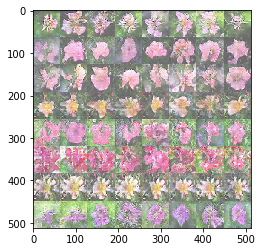

In [147]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./samples/test_visual.png')
imgplot = plt.imshow(img)
plt.show()